# Landcover Classification using AdaBoost

You are supposed to train and apply a boosting model for landcover classification. Below, you can find some code that already parses the data. For your submission, run and submit the extended jupyter notebook.

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


In [4]:
classes = {
    1: "cultivated_land",
    2: "forest",
    3: "grassland",
    4: "shrubland",
    5: "water",
    8: "artificial_surface",
    9: "bareland",
}

In [5]:
def load_data(train_file="./train.npz", test_file="./test.npz", normalize=False):
    """
    Load training and test datasets from .npz files.

    Args:
        train_file (str): Path to training data file. Default: "./train.npz"
        test_file (str): Path to test data file. Default: "./test.npz"
        normalize (bool): Whether to normalize/scale the data. Default: False

    Returns:
        tuple: (X_train, y_train, X_test, y_test)
            - X_train: Training features with original shape
            - y_train: Training labels with original shape
            - X_test: Test features with original shape
            - y_test: Test labels with original shape
    """
    # Load data
    train = np.load(train_file)
    X_train = train["X"]
    y_train = train["y"]

    test = np.load(test_file)
    X_test = test["X"]
    y_test = test["y"]

    if normalize:
        # Store original shapes
        train_shape = X_train.shape
        test_shape = X_test.shape

        # Flatten for StandardScaler (requires 2D input)
        X_train_flat = X_train.reshape(train_shape[0], -1)
        X_test_flat = X_test.reshape(test_shape[0], -1)

        # Apply StandardScaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_flat)
        X_test_scaled = scaler.transform(X_test_flat)

        # Reshape back to original shapes
        X_train = X_train_scaled.reshape(train_shape)
        X_test = X_test_scaled.reshape(test_shape)

    # Assert expected shapes
    assert X_train.shape == (6953, 12, 13, 13, 6), (
        f"Expected training data shape (6953, 12, 13, 13, 6), got {X_train.shape}"
    )
    assert y_train.shape == (6953,), (
        f"Expected training labels shape (6953,), got {y_train.shape}"
    )
    assert X_test.shape == (1739, 12, 13, 13, 6), (
        f"Expected test data shape (1739, 12, 13, 13, 6), got {X_test.shape}"
    )
    assert y_test.shape == (1739,), (
        f"Expected test labels shape (1739,), got {y_test.shape}"
    )

    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = load_data(normalize=True)

In [7]:
print("Class distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {classes[cls]}: {count} samples")

Class distribution in training set:
  cultivated_land: 194 samples
  forest: 4641 samples
  grassland: 901 samples
  shrubland: 617 samples
  water: 45 samples
  artificial_surface: 175 samples
  bareland: 380 samples


## Feature Selection

In [ ]:
def extract_central_pixels(X):
    """
    Extract central pixels from image data.

    Args:
        X: Input data of shape (n_samples, n_timestamps, height, width, n_bands)

    Returns:
        Feature matrix of shape (n_samples, n_timestamps * n_bands)
    """
    n_samples, n_timestamps, height, width, n_bands = X.shape
    center_idx = height // 2  # Central pixel index (6 for 13x13 images)

    # Extract central pixel for all timestamps and bands
    central_features = X[:, :, center_idx, center_idx, :]  # Shape: (n_samples, 12, 6)

    # Flatten to create feature vectors
    features = central_features.reshape(
        n_samples, n_timestamps * n_bands
    )  # Shape: (n_samples, 72)

    return features

In [ ]:
def extract_spatial_features(data, window_sizes=[3, 5]):
    """Extract spatial texture and statistical features"""
    n_samples, n_timestamps, height, width, n_bands = data.shape

    spatial_features = []

    center = height // 2

    for window_size in window_sizes:
        half_window = window_size // 2
        start_idx = center - half_window
        end_idx = center + half_window + 1

        # Extract window around central pixel
        window_data = data[:, :, start_idx:end_idx, start_idx:end_idx, :]

        # Calculate statistics
        mean_val = np.mean(
            window_data, axis=(2, 3)
        )  # (n_samples, n_timestamps, n_bands)
        std_val = np.std(window_data, axis=(2, 3))

        # Flatten for each window size
        spatial_features.extend(
            [
                mean_val.reshape(n_samples, -1),
                std_val.reshape(n_samples, -1),
            ]
        )

    return np.concatenate(spatial_features, axis=1)

In [8]:
def create_features(X, include_spatial=False, window_sizes=[5]):
    """
    Create comprehensive feature set

    Args:
        X: Input data of shape (n_samples, n_timestamps, height, width, n_bands)
        include_spatial (bool): Whether to include spatial features. Default: False
        window_sizes (list): List of window sizes for spatial features. Default: [5]

    Returns:
        Feature matrix combining central pixels and optionally spatial features
    """
    # 1. Central pixel features (baseline)
    central_features = extract_central_pixels(X)

    if include_spatial:
        # 2. Spatial features
        spatial_features = extract_spatial_features(X, window_sizes=window_sizes)

        # Combine all features
        all_features = np.concatenate(
            [
                central_features,  # 72 features
                spatial_features,  # Variable depending on window_sizes
            ],
            axis=1,
        )
    else:
        # Only central pixel features
        all_features = central_features

    return all_features

In [9]:
# Extract features
X_train_central = create_features(X_train, include_spatial=False, window_sizes=[5])
X_test_central = create_features(X_test, include_spatial=False, window_sizes=[5])

print(f"Original training data shape: {X_train.shape}")
print(f"Central pixel features shape: {X_train_central.shape}")
print(f"Number of features per sample: {X_train_central.shape[1]}")

# Flatten labels for sklearn compatibility
y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()


Original training data shape: (6953, 12, 13, 13, 6)
Central pixel features shape: (6953, 72)
Number of features per sample: 72


Class distribution in training set:
  cultivated_land: 194 samples
  forest: 4641 samples
  grassland: 901 samples
  shrubland: 617 samples
  water: 45 samples
  artificial_surface: 175 samples
  bareland: 380 samples


## AdaBoost Model Training and Evaluation

In [ ]:
# Set up grid search parameters
param_grid = {
    "classifier__estimator__max_depth": [1, 2, 3],
    "classifier__n_estimators": [50, 100, 200],
}

# Create base classifier (Decision Tree with Gini impurity)
base_classifier = DecisionTreeClassifier(criterion="gini", random_state=42)

# Create AdaBoost classifier with SAMME algorithm
ada_boost = AdaBoostClassifier(estimator=base_classifier, random_state=42)

# Set up 2-fold cross validation
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Perform grid search
print("Performing grid search with 2-fold cross validation...")
grid_search = GridSearchCV(
    estimator=ada_boost,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

# Fit grid search
grid_search.fit(X_train_central, y_train_flat)

# Print results
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Performing grid search with 2-fold cross validation...
Fitting 2 folds for each of 9 candidates, totalling 18 fits

Best parameters: {'estimator__max_depth': 3, 'n_estimators': 200}
Best cross-validation accuracy: 0.7597

Best parameters: {'estimator__max_depth': 3, 'n_estimators': 200}
Best cross-validation accuracy: 0.7597


In [ ]:
# Parameter combinations to test
parameter_combinations = [(3, 200), (8, 400)]

# Feature configurations to test
feature_configs = [
    {"name": "Central Pixels Only", "include_spatial": False, "window_sizes": [5]},
    {
        "name": "Central + Spatial Features",
        "include_spatial": True,
        "window_sizes": [5],
    },
]

# Store results
results = []

print("Testing different parameter combinations and feature sets:")
print("=" * 60)

for max_depth, n_estimators in parameter_combinations:
    for config in feature_configs:
        print(f"\nTesting max_depth={max_depth}, n_estimators={n_estimators}")
        print(f"Feature set: {config['name']}")

        # Create training and test features with current configuration
        X_train_features = create_features(
            X_train,
            include_spatial=config["include_spatial"],
            window_sizes=config["window_sizes"],
        )
        X_test_features = create_features(
            X_test,
            include_spatial=config["include_spatial"],
            window_sizes=config["window_sizes"],
        )

        print(f"Feature shape: {X_train_features.shape[1]} features")

        # Create base classifier with current parameters
        base_classifier = DecisionTreeClassifier(
            criterion="gini", random_state=42, max_depth=max_depth
        )

        # Create AdaBoost classifier
        ada_boost = AdaBoostClassifier(
            estimator=base_classifier, random_state=42, n_estimators=n_estimators
        )

        # Train the model and measure time
        start_time = time.time()
        ada_boost.fit(X_train_features, y_train_flat)
        end_time = time.time()
        fit_time = end_time - start_time

        # Calculate training accuracy
        train_accuracy = ada_boost.score(X_train_features, y_train_flat)

        # Calculate test accuracy
        y_pred_current = ada_boost.predict(X_test_features)
        test_accuracy = accuracy_score(y_test_flat, y_pred_current)

        # Store results
        result = {
            "max_depth": max_depth,
            "n_estimators": n_estimators,
            "feature_config": config["name"],
            "num_features": X_train_features.shape[1],
            "train_accuracy": train_accuracy,
            "test_accuracy": test_accuracy,
            "fit_time": fit_time,
            "model": ada_boost,
            "predictions": y_pred_current,
        }
        results.append(result)

        print(f"  Training Accuracy: {train_accuracy:.4f}")
        print(f"  Test Accuracy: {test_accuracy:.4f}")
        print(f"  Fit Time: {fit_time:.4f} seconds")


Testing different parameter combinations and feature sets:

Testing max_depth=3, n_estimators=200
Feature set: Central Pixels Only
Feature shape: 72 features
  Training Accuracy: 0.7742
  Test Accuracy: 0.7188

Testing max_depth=3, n_estimators=200
Feature set: Central + Spatial Features
Feature shape: 216 features
  Training Accuracy: 0.8253
  Test Accuracy: 0.7585

Testing max_depth=8, n_estimators=400
Feature set: Central Pixels Only
Feature shape: 72 features
  Training Accuracy: 1.0000
  Test Accuracy: 0.8189

Testing max_depth=8, n_estimators=400
Feature set: Central + Spatial Features
Feature shape: 216 features
  Training Accuracy: 1.0000
  Test Accuracy: 0.8246

SUMMARY OF RESULTS:
max_depth= 3, n_estimators=200, Central Pixels Only       ( 72 features) | Train: 0.7742, Test: 0.7188
max_depth= 3, n_estimators=200, Central + Spatial Features (216 features) | Train: 0.8253, Test: 0.7585
max_depth= 8, n_estimators=400, Central Pixels Only       ( 72 features) | Train: 1.0000, Tes

In [ ]:
# Create DataFrame from results, excluding model and predictions
df_results = pd.DataFrame(
    [
        {
            key: value
            for key, value in result.items()
            if key not in ["model", "predictions"]
        }
        for result in results
    ]
)

df_results.to_latex("results_summary.tex", index=False)


## Confusion Matrix and Detailed Results

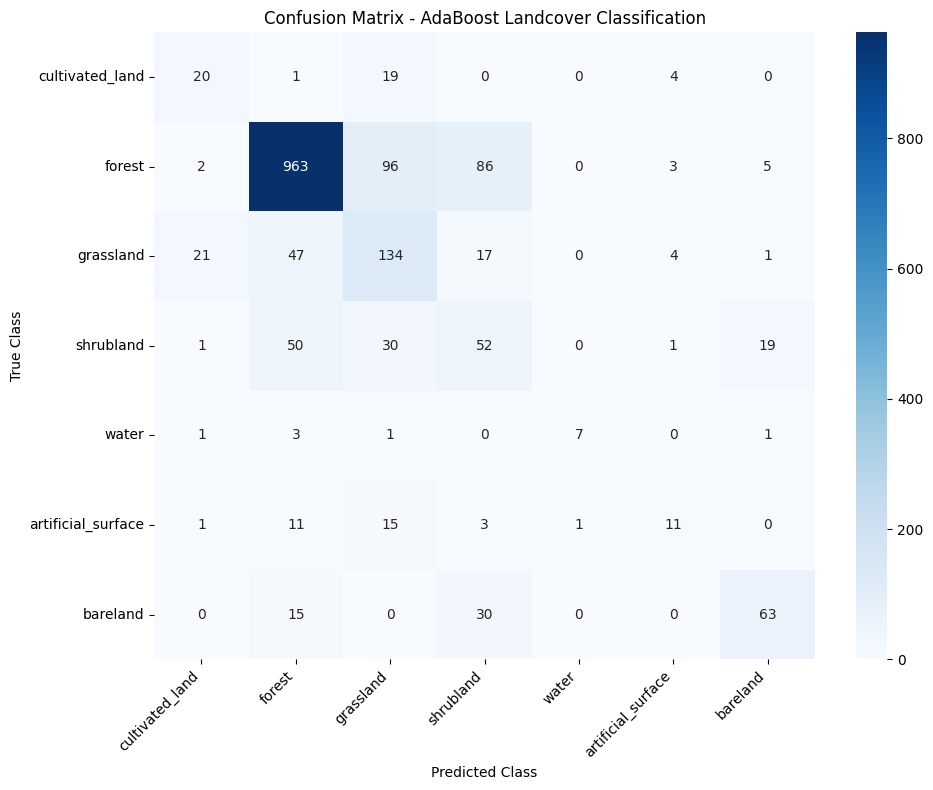


Detailed Classification Report:
                    precision    recall  f1-score   support

   cultivated_land       0.43      0.45      0.44        44
            forest       0.88      0.83      0.86      1155
         grassland       0.45      0.60      0.52       224
         shrubland       0.28      0.34      0.30       153
             water       0.88      0.54      0.67        13
artificial_surface       0.48      0.26      0.34        42
          bareland       0.71      0.58      0.64       108

          accuracy                           0.72      1739
         macro avg       0.59      0.52      0.54      1739
      weighted avg       0.74      0.72      0.73      1739



In [ ]:
# Create confusion matrix

y_pred = results[0]["predictions"]  # Use predictions from the first result

cm = confusion_matrix(y_test_flat, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
class_names = [classes[i] for i in sorted(classes.keys())]
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Confusion Matrix - AdaBoost Landcover Classification")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
